<a href="https://colab.research.google.com/github/Katona-lab/MST-anlysis/blob/main/MST_progress_curve_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Start here by selecting Excel MST file exported by the Nanotemper software
#@markdown Please cite: <br> 
#@markdown Atsarina Larasati Anindya, Maria-Jose Garcia-Bonete, Maja Jensen, Christian V. Recktenwald, Maria Bokarewa and Gergely Katona <i>Bayesian Progress Curve Analysis of MicroScale Thermophoresis Data.</i> 
#@markdown (2022) <b><i>Digital discovery</i></b> 
# (c) 2022 Gergely Katona <gergely.katona@gu.se>
import io
import pandas as pd
from google.colab import files
import numpy as np
import pymc3 as pm
import pylab as plt
import theano.tensor as T
from pymc3.math import switch

#Experimental data description 
uploaded = files.upload()

df=pd.read_excel(io.BytesIO(uploaded[list(uploaded.keys())[0]]),skiprows=16)

cideal=df.iloc[1,1::3]
onedtime=df.iloc[13:,0]

fluorescence=df.iloc[13:,1::3]

Saving MSTTraces_Sgo2_run4.xlsx to MSTTraces_Sgo2_run4.xlsx


In [ ]:
#@title Alternative 1: Perform the MCMC sampling (linear phase starts at -5s)
#@markdown Use scenario: The fluroescence signal (Fnorm) is not stable at 1 before IR irradiation. Possible reasones: photodamage, unstable protein, not fully equilibrated protein:ligand interaction

#@markdown Enter labeled protein concentration in units of nM:
FluoConc =  20#@param {type:"number"}
#@markdown Enter the number of capillaries used in the experiment. The concentration of the ligand will be infered from the data file.
Capillary = "16" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

cap=int(Capillary)
time=np.array([onedtime[:,]]*cap,dtype=float).transpose()
with pm.Model() as model:
    Kd = pm.Uniform('Kd', 1, 1e6)
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1e8)
    FC = BoundedNormal('FC',mu=FluoConc,sd=FluoConc/10.0)

    ampunbound=pm.Beta('ampunbound',alpha=1,beta=1)
    ampbound=pm.Beta('ampbound',alpha=1,beta=1)
    totalamp=pm.Deterministic('totalamp', ampunbound + (ampbound-ampunbound)*((FC + cideal.astype(float) + Kd - pm.math.sqrt(pm.math.sqr(FC + cideal.astype(float) + Kd) - 4.0*FC*cideal.astype(float)))/(2*FC)))

    
    linslope=pm.Uniform('linslope',-1,1, shape=cap)
    level=pm.Deterministic('level',1-linslope*5.0-totalamp)
    ampfract=pm.Beta('ampfract',alpha=2,beta=1, shape=cap)
    amp1=pm.Deterministic('amp1',totalamp*ampfract)
    amp2=pm.Deterministic('amp2',totalamp*(1-ampfract))
    rate1=pm.Lognormal('rate1',0,1, shape=cap)
    rate2=pm.Lognormal('rate2',0,1, shape=cap)

    linearphase=linslope*(time+5.0)
    expcomp1=amp1*pm.math.exp(-1.0*rate1*time)
    expcomp2=amp2*pm.math.exp(-1.0*rate2*time)

    sigma = pm.Lognormal('sigma', 0, 1)
    laseron=np.tile(np.arange(0, 543), (cap,1)).T

    pr = switch(75 >= laseron, 1.0+linearphase, linearphase+level+expcomp1+expcomp2)


    pred = pm.Normal('pred', mu=pr[0:475], sd=sigma, observed=fluorescence.astype(float).iloc[0:475])


with model:
    trace = pm.sampling.sample(2000, tune=1000,
                      init='ADVI'
                     )
    
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000 ,model=model)

In [2]:
#@title Alternative 2: Perform the MCMC sampling (linear phase starts at time 0)
#@markdown Use scenario: Fnorm is stable at 1 before IR irradiation, but after irradiation there is a trendlike increase or decrease in at least some of the progress curves. Possible causes: temperature induced denaturation, direct IR absorption in protein results in electrodynamic interaction between protein and ligand.

#@markdown Enter labeled protein concentration in units of nM:
FluoConc =  20#@param {type:"number"}
#@markdown Enter the number of capillaries used in the experiment. The concentration of the ligand will be infered from the data file.
Capillary = "16" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

cap=int(Capillary)
time=np.array([onedtime[:,]]*cap,dtype=float).transpose()
with pm.Model() as model:
    Kd = pm.Uniform('Kd', 1, 1e6)
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1e8)
    FC = BoundedNormal('FC',mu=FluoConc,sd=FluoConc/10.0)

    ampunbound=pm.Beta('ampunbound',alpha=1,beta=1)
    ampbound=pm.Beta('ampbound',alpha=1,beta=1)
    totalamp=pm.Deterministic('totalamp', ampunbound + (ampbound-ampunbound)*((FC + cideal.astype(float) + Kd - pm.math.sqrt(pm.math.sqr(FC + cideal.astype(float) + Kd) - 4.0*FC*cideal.astype(float)))/(2*FC)))

    
    linslope=pm.Uniform('linslope',-1,1, shape=cap)
    level=pm.Deterministic('level',1-totalamp)
    ampfract=pm.Beta('ampfract',alpha=2,beta=1, shape=cap)
    amp1=pm.Deterministic('amp1',totalamp*ampfract)
    amp2=pm.Deterministic('amp2',totalamp*(1-ampfract))
    rate1=pm.Lognormal('rate1',0,1, shape=cap)
    rate2=pm.Lognormal('rate2',0,1, shape=cap)

    linearphase=linslope*(time)
    expcomp1=amp1*pm.math.exp(-1.0*rate1*time)
    expcomp2=amp2*pm.math.exp(-1.0*rate2*time)

    sigma = pm.Lognormal('sigma', 0, 1)
    laseron=np.tile(np.arange(0, 543), (cap,1)).T

    pr = switch(75 >= laseron, 1.0, linearphase+level+expcomp1+expcomp2)


    pred = pm.Normal('pred', mu=pr[0:475], sd=sigma, observed=fluorescence.astype(float).iloc[0:475])


with model:
    trace = pm.sampling.sample(2000, tune=1000,
                      init='ADVI'
                     )
    
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000 ,model=model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 66200
Interrupted at 66,199 [33%]: Average Loss = 1.4816e+13
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, rate2, rate1, ampfract, linslope, ampbound, ampunbound, FC, Kd]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3763 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [3]:
#@title Statistics of global variables
#@markdown Kd and FC units are traditionally expressed in nM in the Nanotemper software, the amplitudes and sigma is expressed as Fnorm  
pm.stats.summary(trace,var_names=['Kd','ampbound','ampunbound', 'sigma','FC'])


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Kd,1329.267,204.807,978.887,1741.503,6.282,4.443,1060.0,1510.0,1.0
ampbound,0.277,0.001,0.276,0.278,0.000,0.000,1369.0,1865.0,1.0
ampunbound,0.248,0.001,0.246,0.249,0.000,0.000,642.0,1051.0,1.0
sigma,0.002,0.000,0.002,0.002,0.000,0.000,5156.0,2485.0,1.0
FC,20.009,2.006,16.273,23.847,0.029,0.021,4700.0,2457.0,1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  import sys


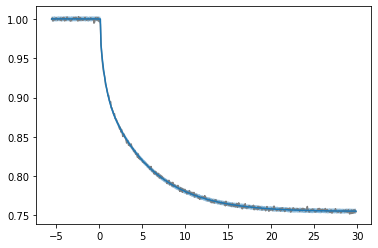

In [20]:
#@title Posterior predictive check { run: "auto" }
#@markdown Choose the capillary to analyse:
Capillary = "16" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

plt.plot(onedtime[:475],fluorescence[int(Capillary)].astype(float).iloc[0:475], color='gray')
plt.plot(onedtime[:475],np.mean(ppc['pred'][:,:,int(Capillary)-1], axis=0))
plt.fill_between(np.array(onedtime[:475],dtype=float), np.array(pm.stats.hdi(ppc['pred'][:,:,int(Capillary)-1])[:,0],dtype=float) ,np.array(pm.stats.hdi(ppc['pred'][:,:,int(Capillary)-1])[:,1],dtype=float) , alpha=0.5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


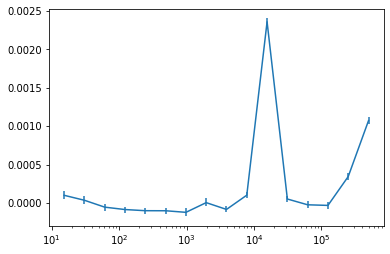

In [28]:
#@title Concentration dependence of the kinetic parameters. { run: "auto" }

#@markdown Choose the variable name:
string = "linslope" #@param ["totalamp","level", "rate1", "rate2", "amp1", "amp2", "linslope"]
fig=plt.subplot(111)
plt.errorbar(cideal,np.median(trace[string],axis=0),yerr=np.abs(pm.hdi(trace[string]).T-np.median(trace[string],axis=0)))
fig.set_xscale('log')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  


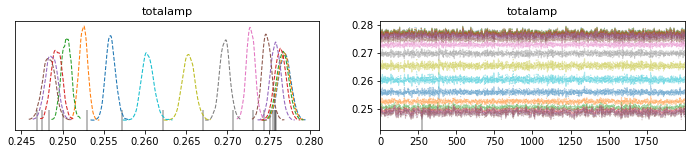

In [34]:
#@title Posterior distribution of model parameters. { run: "auto" }

#@markdown Choose the variable name:
string = "totalamp" #@param ["Kd","ampbound","ampunbound","sigma","totalamp","level", "rate1", "rate2", "amp1", "amp2", "linslope"]
with model:
  ax=pm.traceplot(trace[0:],[string],combined=True)